<a href="https://colab.research.google.com/github/evennybo/AlgoTrade/blob/main/MLP_ReLU_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# Download the historical prices for Tesla from Yahoo Finance
df = yf.download('TSLA', start='2010-01-01', end='2022-03-31')

# Create a new dataframe with only the closing prices
df = df[['Close']]

# Normalize the data using a MinMaxScaler
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Convert the data into input and output sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return X, y

seq_length = 30
X_train, y_train = create_sequences(train_df['Close'].values, seq_length)
X_test, y_test = create_sequences(test_df['Close'].values, seq_length)

[*********************100%***********************]  1 of 1 completed


<ipython-input-75-ec0f4a6139a5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = scaler.fit_transform(df[['Close']])


In [ ]:
# Convert the data into PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the model
input_size = 30
hidden_size = 64

output_size = 1
model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 100
batch_size = 64
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        # Get the minibatch
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([34])) that is different to the input size (torch.Size([34, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.00028883988852612674
Epoch [20/100], Loss: 0.00014126916357781738
Epoch [30/100], Loss: 0.0001118623185902834
Epoch [40/100], Loss: 0.00010619068780215457
Epoch [50/100], Loss: 0.0001029450140777044
Epoch [60/100], Loss: 0.0001001069467747584
Epoch [70/100], Loss: 9.981393668567762e-05
Epoch [80/100], Loss: 9.960316674550995e-05
Epoch [90/100], Loss: 9.908654465107247e-05
Epoch [100/100], Loss: 9.8671909654513e-05


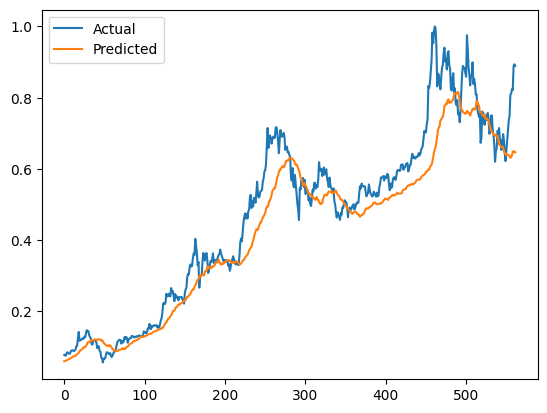

In [ ]:
y_pred = model(X_test)
y_test = y_test.detach().numpy()
y_pred = y_pred.detach().numpy()

results_df = pd.DataFrame({'actual': y_test.flatten(), 'predicted': y_pred.flatten()})

plt.plot(results_df['actual'], label='Actual')
plt.plot(results_df['predicted'], label='Predicted')
plt.legend()
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #mps instead of cuda

In [ ]:
results_df.transform

,actual,predicted
0,0.077659,0.060065
1,0.075898,0.060836
2,0.075378,0.061864
3,0.082993,0.062299
4,0.085122,0.063671
...,...,...
557,0.823933,0.639337
558,0.821259,0.647718
559,0.887451,0.650203
560,0.893752,0.646131


In [ ]:
model.eval()

with torch.no_grad():
    y_pred = model(X_test)

  #print("Testing Accuracy: {:.2f}%".format(accuracy * 100))